# Linear Regression with Regularization

## Table of Content

[Regression Analysis Part 1: Assumptions for Linear Regression]

[Regression Analysis Part 2: Linear Regression with Regularization]

[Regression Analysis Part 3: Parametric and Nonparametric regression]

[Regression Analysis Part 4: Deep Dive into Loss Functions]

## Overview

Machine Learning problem can be divided into two sub-categories -- **`Classification`** and **`Regression`** problem.
* **`Classification`** refers to the task of assigning labels *`(yes/no, True/False, Ham/Spam)`* to data samples belonging to different classes. 

It can either be a two-class classification problem (mostly using **sigmoid function**) or a multi-class classifcation problem (mostly using **softmax function**). 

* **`Regression`**, on the other hand, refers to the task of predicting continuous values (scalar) by depicting the relationship between dependent variables and various independent features.

`Linear Regression`, therefore, performs the task to predict a dependent variable value (y) based on a given independent variable (x) in a linear line. To find the line, **Ordinary Least Squared Method (OLS)** is widely used for regression problem. 

For complex problems, **`multivariate regression / Polynomial regression / Regularization term`** is utilized to enhance performance while at the same time restraining loss. 

In this notebook, we will first look at some basic assumptions behind a robust linear regression model.

We will discuss what the assumptions are, and, if those assumptions are not satisfied, possible ways to transfrom our data.

---

## Notebook Setting

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

Here we will use the famous Boston Housing Dataset.

In [50]:
from sklearn.datasets import load_boston

boston_dataset = load_boston()

boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['Target'] = boston_dataset.target
boston = boston[boston.columns[-1:].append(boston.columns[:-1])]
boston.head()

,Target,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [67]:
boston.isnull().values.any()

False

**No null value is detected. It's good to go!**

---

## Loss Function

To evaluate the performance of the regression model, various loss functions are introduced and are preferred in different scenario.

<img src='loss_all.png' width="400" height="150">

We will first **`RMSE (Root Mean Squared Error)`** to evaluate the practice toy example below. At the end of this notebook, we will dive deeper into difference loss function / metrics as well as their respective strength and weaknesses

## Preparation

In [7]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split

In [8]:
X = boston.drop(columns=['Target'])
y = boston['Target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Linear Regression from Scratch

One approch to solve linear regression problem is to get the closed-form solution as below:

<img src='closedform.png' width="300" height="150">

Another appraoch to solve this problem is through gradient descent.

In [350]:
class LinearRegression:
    def __init__(self, fit_intercept = True, lr = 0.00000001,  n_iter = int(1e5)):
        """
        Initialize trhe calss
        fit_intercept: Boolean switch to indicate whether 
                       to include an intercept in the model.
        """
        self.coef_ = None
        self.intercept_ = None
        self._fit_intercept = fit_intercept
        self.n_features = X.shape[1]
        self.n_samples = len(y)
        self.n_iter = n_iter
        self.lr = lr
        self.X = np.hstack((np.ones((self.n_samples, 1)), # initialize the bias term
                            (X - np.mean(X, 0)) / np.std(X, 0))) # z-score
        self.y = y[:, np.newaxis] # 
        self.params = np.random.random((X.shape[1] + 1, 1)) / 10 # randomize coefficients

    def __repr__(self): # show discription when called
        return "I am a Linear Regression model!"
    
    def fit(self, X, y, gradient = False):
        """
        Fit model coefficients.
        
        Arguments:
        X: 1D or 2D numpy array
        y: 1D numpy array
        gradient: if True, use gradient descent. if False, use closed-form solution.
        """
        if gradient: # gradient descent

            for iteration in range(self.n_iter):
                # Hypothesis Values
                loss = self.X.dot(self.params) - self.y

                # Gradient Calculation
                gradient = self.X.T.dot(loss) / self.n_samples
                
                # Changing Values of B using Gradient
                self.params = self.params - self.lr * gradient
                
            if self._fit_intercept:
                self.intercept_ = self.params[0]
                self.coef_ = self.params[1:]            

            
        else: # closed-form solution
            
            # check if X is 1D or 2D array
            if len(X.shape) == 1:
                X = X.reshape(-1,1)

            # add bias if fit_intercept is True
            if self._fit_intercept:
                X_biased = np.c_[np.ones(X.shape[0]), X]
            else:
                X_biased = X

            # closed form solution
            xTx = np.dot(X_biased.T, X_biased)
            inverse_xTx = np.linalg.inv(xTx)
            xTy = np.dot(X_biased.T, y)
            self.params = np.dot(inverse_xTx, xTy)

            # set attributes
            if self._fit_intercept:
                self.intercept_ = self.params[0]
                self.coef_ = self.params[1:]
    
    def predict(self, X):
        """
        Output model prediction.
        
        Arguments:
        X: 1D or 2D numpy array.
        """
        
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
        
        self.predicted_ = self.intercept_ + np.dot(X, self.coef_)
        return(self.predicted_)

In [237]:
mlr = LinearRegression()

In [238]:
print(mlr)
print(mlr.coef_)

I am a Linear Regression model!
None


In [239]:
mlr.fit(X_train, y_train, gradient=False)

In [240]:
print(mlr)
print(f'The coefficients are {mlr.coef_}.')

I am a Linear Regression model!
The coefficients are [ -0.0964   0.0352   0.0288   2.5155 -16.5174   3.9191   0.0063  -1.3609
   0.293   -0.0111  -1.0205   0.0093  -0.5455].


In [241]:
print(f'The intercept for this regression line is {mlr.intercept_}.')

The intercept for this regression line is 35.401846309894154.


In [242]:
pred = mlr.predict(X_test)

In [243]:
rmse(pred, y_test)

4.039883672665205

24.0

In [347]:
mlr = LinearRegression()
mlr.fit(X_train, y_train, gradient=True)

In [348]:
print(mlr)
print(f'The coefficients are {mlr.coef_}.')

I am a Linear Regression model!
The coefficients are [[0.0131]
 [0.0848]
 [0.0302]
 [0.0113]
 [0.0932]
 [0.0946]
 [0.01  ]
 [0.0074]
 [0.0416]
 [0.038 ]
 [0.0098]
 [0.0122]
 [0.061 ]].


In [349]:
pred = mlr.predict(X_test)
rmse(pred, y_test)

array([13.449])

## Benchmark -- Ordinary Least Square (OLS)

A normal linear regression is a statistical method that models the relationship between variables. In regression, it is believed that the relationship between two variables can be explained by the formula:

<img src='lr.png' width="200" height="100">

<img src='error.png' width="400" height="150">

**`εi`**: the error term between the line and the data point

**`α`** : intercept of the regression time. 

**`β`** : coefficient of the variable. It represents the variation of the dependent variable when the independent variable changes.

**`α, β`** are the unobserved parameters that we want to retrieve from this regression model.

In [10]:
lr = LinearRegression(normalize=True)

In [11]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [12]:
lr_pred = lr.predict(X_test)

In [119]:
# Calculate root mean squared error
def rmse(pred, y_test):
    sum_err = 0.0
    y = y_test.values
    for i in range(len(y_test)):
        err = pred[i] - y[i]
        sum_err += (err**2)
    return(np.sqrt(sum_err / float(len(pred))))

In [14]:
rmse(lr_pred, y_test)

4.872627447456344

## Why Regularization is important?

<img src="regu.png" width="600" height="400">

Source: https://www.researchgate.net/figure/A-schematic-illustration-of-how-different-regularization-terms-lead-to-sparse-and_fig3_236461343

## Lasso Regression (L1 Regularization)

<img src="lasso.png" width="600" height="400">

pic source: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

In [15]:
lasso = LassoCV(normalize=True, cv = 5)

In [16]:
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

In [17]:
rmse(lasso_pred,y_test)

4.866166107262425

### L1 Regularization as a Feature Selection Tool

Lasso regression is widely used in feature selection, since it can shrink the coeffiecient of non-important features to zero.

https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [20]:
selector = SelectFromModel(LassoCV())
selector.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [21]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

If return == 'True', it means that the variable is important (will not shrink to zero.)


If return == 'False', it means that the variable is not important and will shrink to zero!

If so, we can drop those features.


For now, it's good to go!

---

## Ridge Regression

<img src="ridge.png" width="600" height="400">

pic source: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

In [22]:
ridge = RidgeCV(normalize=True, cv = 5, gcv_mode='auto')

In [23]:
ridge.fit(X_train,y_train)
ridge_pred = ridge.predict(X_test)

In [24]:
rmse(ridge_pred,y_test)

4.950150317071678

### Let's compare the result with polynomial features!

The order for polynomial coefficient is `['intercept', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']`

Thus, we will retrieve the coef for the 13 variables with slicer `[1:14]`

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [34]:
poly = np.arange(1,6)
def regression(poly, model_string):
    
    if model_string == 'linear':
        model = LinearRegression(normalize=True)
    elif model_string == 'lasso':
        model = LassoCV(normalize=True, cv = 5)
    elif model_string == 'ridge':
        model = RidgeCV(normalize=True, cv = 5, gcv_mode='auto')
    elif model_string == 'elastic':
        model = ElasticNetCV(normalize=True, cv = 5)
    else:
        model = False
    
    if model != False:
        err_set = []
        coef_set = []
        for i in poly:
            start = datetime.now()
            mod = Pipeline(steps=[    
            ('polynomial',PolynomialFeatures(i)),
            ('model',model)
            ])
            mod.fit(X_train, y_train)
            pred = mod.predict(X_test)
            error = rmse(pred, y_test)
            coef = [np.round(i,2) for i in mod.named_steps['model'].coef_[1:boston.shape[1]]] # retrieve coef from model within the pipeline
            print(f"Power: {i} Error: {error:.4f} Time: {datetime.now() - start}")
            print(f"Coef: {coef}")
            err_set.append(error)
            coef_set.append(coef)
        return(err_set, coef_set)
    else:
        print('Please select model from "linear", "lasso", and "ridge".')

In [31]:
lin_err, lin_coef = regression(poly, 'linear')

Power: 1 Error: 4.8726 Time: 0:00:00.003805
Coef: [-0.11, 0.05, -0.05, 3.21, -17.44, 3.94, -0.01, -1.54, 0.36, -0.01, -0.92, 0.01, -0.45]
Power: 2 Error: 3.7097 Time: 0:00:00.016734
Coef: [0.21, 0.08, -5.39, 10.2, 1.42, 4.9, 1.15, -7.33, 3.46, 0.03, 0.35, -0.05, -0.42]
Power: 3 Error: 95.4778 Time: 0:00:00.055040
Coef: [18.91, 10.92, -16.78, 33.45, -2852.92, -1049.48, -19.17, 39.54, 63.14, 1.3, 17.15, -3.87, 20.45]
Power: 4 Error: 28.8051 Time: 0:00:00.133760
Coef: [-0.82, 0.18, 2.64, 0.36, 242.81, 56.88, -1.06, -11.96, 0.64, 0.0, -2.56, -0.03, 2.73]
Power: 5 Error: 26.4644 Time: 0:00:00.467118
Coef: [-0.21, 0.01, 0.53, -0.09, 74.04, 20.86, -0.25, -3.09, 0.21, -0.0, -2.03, -0.01, 0.69]


In [32]:
lasso_err, lasso_coef = regression(poly, 'lasso')

Power: 1 Error: 4.8662 Time: 0:00:00.062687
Coef: [-0.11, 0.04, -0.05, 3.21, -17.22, 3.96, -0.01, -1.51, 0.35, -0.01, -0.92, 0.01, -0.45]
Power: 2 Error: 3.9077 Time: 0:00:00.676004
Coef: [0.07, -0.23, 0.42, 0.0, 0.0, -0.0, 0.11, -0.0, 0.0, -0.0, -0.0, 0.04, -0.29]
Power: 3 Error: 4.1019 Time: 0:00:15.499635
Coef: [-0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.62, 0.32, 0.0, -0.0, 0.0, -0.0]
Power: 4 Error: 3.9545 Time: 0:01:23.787725
Coef: [-0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.05, -0.94, 0.0, 0.0, -0.0, 0.0, -0.0]
Power: 5 Error: 4.6448 Time: 0:06:35.422125
Coef: [-0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0]


In [33]:
ridge_err, ridge_coef = regression(poly, 'ridge')

Power: 1 Error: 4.9502 Time: 0:00:00.036065
Coef: [-0.08, 0.02, -0.09, 3.41, -11.05, 4.16, -0.01, -1.03, 0.16, -0.0, -0.81, 0.01, -0.4]
Power: 2 Error: 4.3506 Time: 0:00:00.042659
Coef: [0.0, -0.01, 0.03, 0.27, -2.5, 1.64, 0.01, -0.21, 0.08, -0.0, -0.22, 0.0, -0.04]


/Users/ytchou/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Power: 3 Error: 4.1180 Time: 0:00:00.483280
Coef: [0.0, -0.01, 0.01, -0.1, 0.58, 0.89, 0.01, -0.17, 0.05, 0.0, -0.1, 0.0, -0.01]
Power: 4 Error: 4.3446 Time: 0:00:00.759190
Coef: [0.0, -0.0, -0.01, -0.18, 0.21, 0.67, 0.01, -0.11, 0.03, 0.0, -0.06, 0.0, -0.01]
Power: 5 Error: 4.6731 Time: 0:00:00.946291
Coef: [-0.0, -0.0, -0.0, -0.03, -0.03, 0.22, 0.0, -0.02, 0.01, 0.0, -0.02, 0.0, -0.0]


/Users/ytchou/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [35]:
en_err, en_coef = regression(poly, 'elastic')

Power: 1 Error: 4.9811 Time: 0:00:00.056917
Coef: [-0.08, 0.02, -0.1, 3.39, -10.13, 4.16, -0.01, -0.94, 0.13, -0.0, -0.78, 0.01, -0.39]
Power: 2 Error: 4.4301 Time: 0:00:00.417989
Coef: [-0.0, -0.0, 0.02, 0.17, -2.79, 1.58, 0.0, -0.16, 0.07, -0.0, -0.24, 0.0, -0.05]
Power: 3 Error: 4.2081 Time: 0:00:21.568463
Coef: [0.0, -0.0, 0.02, -0.0, 0.28, 0.81, 0.0, -0.12, 0.04, 0.0, -0.1, 0.0, -0.01]
Power: 4 Error: 4.2758 Time: 0:02:08.451227
Coef: [-0.0, -0.0, -0.0, -0.0, 0.0, 0.57, 0.0, -0.07, 0.02, 0.0, -0.07, 0.0, -0.01]
Power: 5 Error: 4.5289 Time: 0:08:21.072499
Coef: [-0.0, -0.0, -0.0, -0.0, -0.0, 0.33, 0.0, -0.03, 0.01, -0.0, -0.03, 0.0, -0.01]


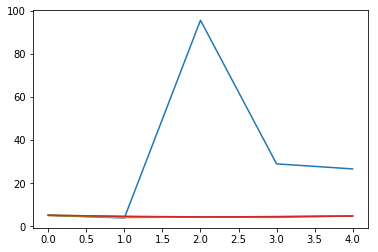

In [44]:
plt.plot(lin_err)
plt.plot(lasso_err)
plt.plot(ridge_err)
plt.plot(en_err)

In [56]:
dic = {}
dic['Lasso'] = lasso_err
dic['Ridge'] = ridge_err
dic['ElasticNet'] = en_err

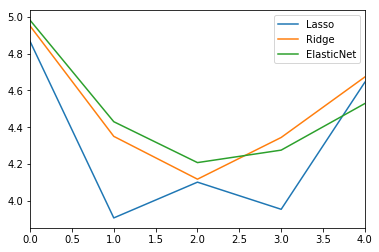

In [57]:
pd.DataFrame(dic).plot()

In [81]:
lasso = {}
for i,v in enumerate(lasso_coef):
    lasso[i] = v

col = ['coef1','coef2','coef3','coef4','coef5','coef6','coef7','coef8','coef9','coef10','coef11','coef12','coef13']
df_lasso = pd.DataFrame(lasso,index=col).T

In [82]:
ridge = {}
for i,v in enumerate(ridge_coef):
    ridge[i] = v

col = ['coef1','coef2','coef3','coef4','coef5','coef6','coef7','coef8','coef9','coef10','coef11','coef12','coef13']
df_ridge = pd.DataFrame(ridge,index=col).T

In [83]:
elastic = {}
for i,v in enumerate(en_coef):
    elastic[i] = v

col = ['coef1','coef2','coef3','coef4','coef5','coef6','coef7','coef8','coef9','coef10','coef11','coef12','coef13']
df_elastic = pd.DataFrame(elastic,index=col).T

In [85]:
df_lasso

,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13
0,-0.11,0.04,-0.05,3.21,-17.22,3.96,-0.01,-1.51,0.35,-0.01,-0.92,0.01,-0.45
1,0.07,-0.23,0.42,0.00,0.00,-0.00,0.11,-0.00,0.00,-0.00,-0.00,0.04,-0.29
2,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.62,0.32,0.00,-0.00,0.00,-0.00
3,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.05,-0.94,0.00,0.00,-0.00,0.00,-0.00
4,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00


In [86]:
df_ridge

,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13
0,-0.08,0.02,-0.09,3.41,-11.05,4.16,-0.01,-1.03,0.16,-0.0,-0.81,0.01,-0.40
1,0.00,-0.01,0.03,0.27,-2.50,1.64,0.01,-0.21,0.08,-0.0,-0.22,0.00,-0.04
2,0.00,-0.01,0.01,-0.10,0.58,0.89,0.01,-0.17,0.05,0.0,-0.10,0.00,-0.01
3,0.00,-0.00,-0.01,-0.18,0.21,0.67,0.01,-0.11,0.03,0.0,-0.06,0.00,-0.01
4,-0.00,-0.00,-0.00,-0.03,-0.03,0.22,0.00,-0.02,0.01,0.0,-0.02,0.00,-0.00


In [87]:
df_elastic

,coef1,coef2,coef3,coef4,coef5,coef6,coef7,coef8,coef9,coef10,coef11,coef12,coef13
0,-0.08,0.02,-0.10,3.39,-10.13,4.16,-0.01,-0.94,0.13,-0.0,-0.78,0.01,-0.39
1,-0.00,-0.00,0.02,0.17,-2.79,1.58,0.00,-0.16,0.07,-0.0,-0.24,0.00,-0.05
2,0.00,-0.00,0.02,-0.00,0.28,0.81,0.00,-0.12,0.04,0.0,-0.10,0.00,-0.01
3,-0.00,-0.00,-0.00,-0.00,0.00,0.57,0.00,-0.07,0.02,0.0,-0.07,0.00,-0.01
4,-0.00,-0.00,-0.00,-0.00,-0.00,0.33,0.00,-0.03,0.01,-0.0,-0.03,0.00,-0.01


### End Note

---

## Reference :

https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155

https://towardsdatascience.com/object-oriented-programming-for-data-scientists-build-your-ml-estimator-7da416751f64

https://stats.stackexchange.com/questions/336860/derivation-of-the-closed-form-solution-to-minimizing-the-least-squares-cost-func

https://medium.com/@pytholabs/multivariate-linear-regression-from-scratch-in-python-5c4f219be6a

https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c

https://github.com/pavannaik3009/BostonHousingProject/blob/master/Regularization%20for%20Regression.ipynb